In [1]:
import pymorphy2
from sklearn import *
from sklearn.feature_extraction.text import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
import nltk
import pandas as pd
from nltk.corpus import stopwords

In [2]:
nltk.download('stopwords')
stops = (stopwords.words('english'))

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1091)>


In [3]:
df_train = pd.read_csv('train_spam.csv')
df_train

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


In [4]:
#Лемматизация текста и подключение стоп-словаря

In [5]:
morph = pymorphy2.MorphAnalyzer()
def get_data(text): 
    texts = [word.lower() for word in text.split() if word.isalpha()][1:]
    for word in texts:
        #print(word)
        if word in stops:
            texts.remove(word)
    return lemmatize(texts)

def lemmatize(texts):
    return [(' '.join([morph.parse(word)[0].normal_form for word in texts]))]

In [6]:
ind = []
texts = []
for i, element in enumerate(df_train['text_type']):
    texts += get_data(df_train['text'][i])
    if element == 'ham':
        ind.append(0) #метки НЕ спама
    else:
        ind.append(1) #метки спама
df_train['indexes'] = ind
df_train['lemmatized'] = texts

<AxesSubplot:>

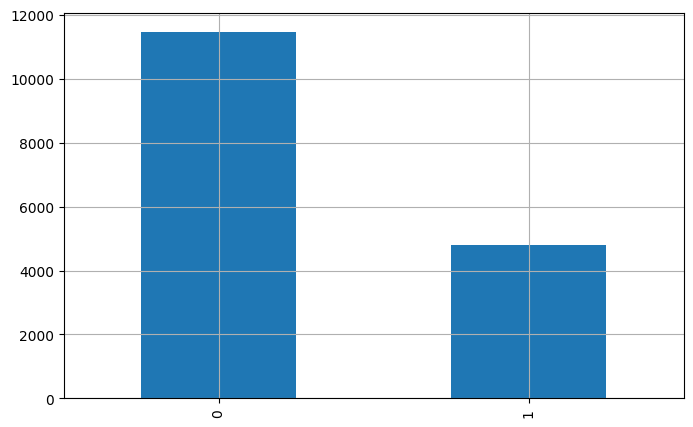

In [7]:
counts = df_train['indexes'].value_counts()
counts.plot(kind='bar', legend=False, grid=True, figsize=(8, 5))

In [8]:
df_train

,text_type,text,indexes,lemmatized
0,ham,make sure alex knows his birthday is over in f...,0,sure alex knows birthday over fifteen minutes ...
1,ham,a resume for john lavorato thanks vince i will...,0,resume john lavorato thanks vince get moving i...
2,spam,plzz visit my website moviesgodml to get all m...,1,visit website moviesgodml get movies free also...
3,spam,urgent your mobile number has been awarded wit...,1,mobile number been awarded a prize guaranteed ...
4,ham,overview of hr associates analyst project per ...,0,hr associates analyst project per david reques...
...,...,...,...,...
16273,spam,if you are interested in binary options tradin...,1,are interested binary options trading i may co...
16274,spam,dirty pictureblyk on aircel thanks you for bei...,1,pictureblyk aircel thanks a valued member here...
16275,ham,or you could do this g on mon 1635465 sep 1635...,0,could g mon sep david rees wrote mon sep rob w...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...,0,reels par bhara pada hai kuch bhi dalte cringe...


In [9]:
x, y = df_train.lemmatized, df_train.indexes
x_train, x_val, y_train, y_val = train_test_split(x, y, 
                                                    train_size=0.8, 
                                                    random_state=42)
scores = []
Models_train = []
models = [LogisticRegression,KNeighborsClassifier, tree.DecisionTreeClassifier,
         LinearSVC, NearestCentroid, MultinomialNB, RandomForestClassifier]

In [10]:
def classific(name):
    text_clf = Pipeline([('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('clf', name()),
            ])

    text_clf.fit(x_train, y_train)

    predicted = text_clf.predict(x_val)

    SVC = (metrics.classification_report(y_val, predicted))
    name = str(name)
    name = name.split('.')
    name = name[-1].replace("'",'').replace('>','')
    print(f'========================= {name} =========================')
    print(SVC)
    print('Roc_auc = ', (round(roc_auc_score(y_val, predicted), 2)))
    print('__'*50)
    scores.append(round(roc_auc_score(y_val, predicted), 2))
    Models_train.append(f'{name}')

def test_classific(name, x_test):
    text_clf = Pipeline([('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('clf', name()),
            ])

    text_clf.fit(x_train, y_train)

    predicted = text_clf.predict(x_test)
    return predicted

In [11]:
for mod in models:
    classific(mod)

========================= LogisticRegression =========================
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2321
           1       0.93      0.79      0.86       935

    accuracy                           0.92      3256
   macro avg       0.92      0.88      0.90      3256
weighted avg       0.92      0.92      0.92      3256

Roc_auc =  0.88
____________________________________________________________________________________________________
========================= KNeighborsClassifier =========================
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      2321
           1       0.96      0.19      0.31       935

    accuracy                           0.76      3256
   macro avg       0.85      0.59      0.59      3256
weighted avg       0.81      0.76      0.70      3256

Roc_auc =  0.59
_____________________________________________________________________

In [12]:
df_res = pd.DataFrame(zip(Models_train, scores))
df_res.style.highlight_min(color = 'red', axis = 0, subset = [1]).highlight_max(color = 'lightgreen', axis = 0, subset = [1])

,0,1
0,LogisticRegression,0.880000
1,KNeighborsClassifier,0.590000
2,DecisionTreeClassifier,0.880000
3,LinearSVC,0.920000
4,NearestCentroid,0.860000
5,MultinomialNB,0.790000
6,RandomForestClassifier,0.890000


In [13]:
#Наиболее высокие результаты показала модель метода опорных векторов, воспользуемся ей для тестовых данных

In [14]:
df_test = pd.read_csv('test_spam.csv')
df_test

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...
...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...
4066,baylor enron case study cindy yes i shall co a...
4067,boring as compared to tp
4068,hellogorgeous hows u my fone was on charge lst...


In [15]:
texts = []
for i, element in enumerate(df_test['text']):
    texts += get_data(df_test['text'][i])
df_test['lemmatized'] = texts

In [16]:
x_test = df_test.lemmatized
df_test['score'] = test_classific(LinearSVC, x_test)
df_test

,text,lemmatized,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,jim whitehead ejw cse ucsc edu writes j open s...,0
1,original message from bitbitch magnesium net p...,message bitbitch magnesium net people screamin...,0
2,java for managers vince durasoft who just taug...,managers vince durasoft just taught java class...,0
3,there is a youtuber name saiman says,a youtuber name saiman says,0
4,underpriced issue with high return on equity t...,issue high return equity oil gas advisory oil ...,1
...,...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,wifetum meri zindagi hoorwifeor kyatell or kya...,0
4066,baylor enron case study cindy yes i shall co a...,enron case study cindy yes shall co author pap...,0
4067,boring as compared to tp,compared tp,0
4068,hellogorgeous hows u my fone was on charge lst...,hows u fone on charge lst nitw wen u texd hope...,0


<AxesSubplot:>

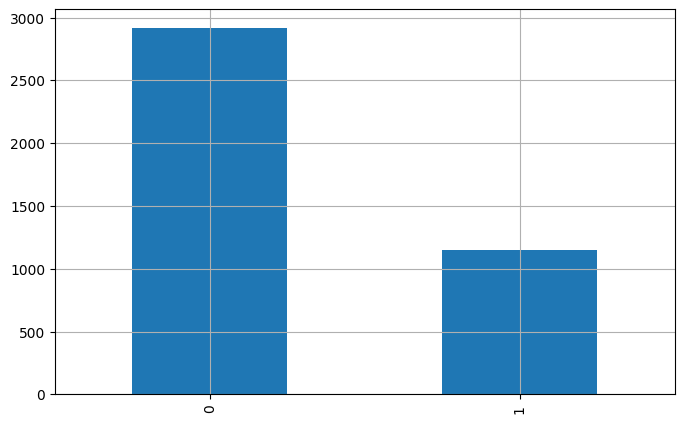

In [17]:
counts = df_test['score'].value_counts()
counts.plot(kind='bar', legend=False, grid=True, figsize=(8, 5))

In [18]:
df_test.drop('lemmatized', axis= 1 , inplace= True )
df_test = df_test[['score', 'text']]
df_test

,score,text
0,0,j jim whitehead ejw cse ucsc edu writes j you ...
1,0,original message from bitbitch magnesium net p...
2,0,java for managers vince durasoft who just taug...
3,0,there is a youtuber name saiman says
4,1,underpriced issue with high return on equity t...
...,...,...
4065,0,husband to wifetum meri zindagi hoorwifeor kya...
4066,0,baylor enron case study cindy yes i shall co a...
4067,0,boring as compared to tp
4068,0,hellogorgeous hows u my fone was on charge lst...


In [19]:
df_test.to_csv('results.csv', index=False)